# Fraud/Intrusion Detection

Fraud detection is a novelty detection problem. Given many transactions that are seemingly "normal", when a new transaction that is significantly different ("outlier") from that pattern is detected, we want to flag that as a fraudulent transaction or undesired intrusion. If you do not build such anamolous activity intelligence into your operational hum, the harm may be realized too late in the process. Instead of retroactive correction measures, you want to build preventive guards around your operations. 

Underneath, we consider one simulated example of a network intrusion activity. We train the system to recognize normality from intrusion activity so the system can self-guard againt undesired instrusions. This use case is very similar to the guard rails that your credit card processor builds around flagging fraudulent activity in near realtime. Perhaps they also use rule-based expert systems besides the statistical models, but this provides a decent start.

We will use multi-attribute dataset at https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/. The dataset in this case is flagging if a network activity is part of a normal business or if it is an anamolous/suspicious activity which is guessed based on parameters like port activity, packet lengths etc.

## Data

Obtain the published dataset from the UCI website. The names and data are misaligned a little. Let us download and overlay correct feature semantics.

In [1]:
# Initialize the URI
uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.data_10_percent.gz'

import itertools

# Get all feature names in the dataset from a metadata page
feature_names = [
    name_type.split(':')[0]
    for name_type in list(
        itertools.chain(*pd.read_csv(
            'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.names',
            skiprows=1).values))
] + ['is_attack']  # append the class of record in the last column

# Get fraudulent data
fraud_data_all = pd.read_csv(uri, names=feature_names, compression='gzip')

# Convert the status of attack type to a boolean flag
fraud_data_all['is_attack'] = fraud_data_all['is_attack'].apply(
    lambda x: 1 if x == 'normal.' else 0)

# Display the data
pd_display(fraud_data_all, "Network metric samples under normal and anamolous/intrusion conditions")

,protocol_type,service,flag,src_bytes,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,is_attack
0,tcp,http,SF,181,...,0.00,0.0,0.0,1
0,tcp,http,SF,239,...,0.00,0.0,0.0,1
0,tcp,http,SF,235,...,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
0,tcp,http,SF,203,...,0.01,0.0,0.0,1
0,tcp,http,SF,291,...,0.01,0.0,0.0,1
0,tcp,http,SF,219,...,0.01,0.0,0.0,1


## "Normal" Activity

The labeled data contains both normal and intrusion activity samples. We want to train our machine to gain an understanding of normal behavior first, so when encountering outlier activity, the machine can take evasive measures.

Let us separate the normal and outlier samples.

In [2]:
%matplotlib inline
# We will train on normal behavior
# When the class of record is 1, the record is indicative of normal_activity, 
# when it is 0 it is anamolous activity
good_txns = fraud_data_all[fraud_data_all.is_attack == 1]

# Display good txns
pd_display(good_txns, "Normal activity ~20% activity is normal")

,protocol_type,service,flag,src_bytes,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,is_attack
0,tcp,http,SF,181,...,0.00,0.0,0.0,1
0,tcp,http,SF,239,...,0.00,0.0,0.0,1
0,tcp,http,SF,235,...,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
0,tcp,http,SF,203,...,0.01,0.0,0.0,1
0,tcp,http,SF,291,...,0.01,0.0,0.0,1
0,tcp,http,SF,219,...,0.01,0.0,0.0,1


## Continuous Frame

The data contains continuous attributes as well as categorical attributes. And some label attributes. We will need to convert data into a continuous (floating point attributes) to continue analysis. Let us use one-hot encoding to convert categorical attributes into numeric attributes.

In [3]:
# Since there are categorical attributes, let us convert to continuous dataframe
from sklearn.preprocessing import MinMaxScaler

# Create a scaler to change column values to lie between 0 and 1
scaler = MinMaxScaler()

# Flattened table
unscaled_txns = pd.get_dummies(
    fraud_data_all.convert_objects(convert_numeric=True))

# Normalize columns
flat_txns = pd.DataFrame(
    scaler.fit_transform(unscaled_txns), columns=[unscaled_txns.columns])

# Good txns again
norm_txns = flat_txns[flat_txns.is_attack == 1]

# Bad txns again
abnorm_txns = flat_txns[flat_txns.is_attack != 1]

# Display the frame
pd_display(norm_txns, "All activity normalized on continuous scale")

,src_bytes,dst_bytes,land,wrong_fragment,...,flag_S2,flag_S3,flag_SF,flag_SH
0,2.61e-07,1.06e-03,0.0,0.0,...,0.0,0.0,1.0,0.0
1,3.45e-07,9.43e-05,0.0,0.0,...,0.0,0.0,1.0,0.0
2,3.39e-07,2.59e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
494018,2.93e-07,2.33e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
494019,4.20e-07,2.33e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
494020,3.16e-07,2.39e-04,0.0,0.0,...,0.0,0.0,1.0,0.0


## Train

Let us train the machine on normal state. Hold 2% for testing the performance of our engine.

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# Split the training set and leave 2% for validation
(train_set, test_set) = train_test_split(flat_txns.copy(), test_size=0.02)

train_set = train_set[train_set.is_attack == 1]

# Drop the class label; we do not want to be biased to the existing real label
X_set = lambda df: df.drop(['is_attack'], axis=1)

# Merge with non-attack/normative set
X_train = X_set(train_set)

pd_display(X_train, "Training set without the prior label attribute")

,src_bytes,dst_bytes,land,wrong_fragment,...,flag_S2,flag_S3,flag_SF,flag_SH
80066,2.86e-07,9.17e-05,0.0,0.0,...,0.0,0.0,1.0,0.0
13094,2.91e-07,7.30e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
84148,3.81e-07,1.44e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
457438,1.00e-06,6.42e-05,0.0,0.0,...,0.0,0.0,1.0,0.0
39143,4.85e-07,3.37e-04,0.0,0.0,...,0.0,0.0,1.0,0.0
32710,4.76e-07,6.01e-04,0.0,0.0,...,0.0,0.0,1.0,0.0


## OneClassSVM classifier

Create a binary engine to learn normal activity from anamolous activity

In [5]:
# Create a classifier and fit
clf = svm.OneClassSVM(nu=0.005)

# We onyl feed good activity to the OneClassSVM classifier. We do not want to pollute with anamolous samples
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.005, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

## Visualize

There are over 117 features that describe the recorded attributes. But since we trained the OneClassSVM for normal activity, it is apt to imagine the classifier is demarking globs of areas in this hyperspace where common good traits are observed. Anything outside these sage glob zones may be assumed as outliers. 

Let us plot the globs of good transactions on a two dimensional plot to visualize "hot-spots" of normalcy and "not-spots" of outliers. Since we have many dimensions (~117), we first reduce the dimensionality to three to visualize the globs.

,x,y,z
0,-0.68,-0.06,-0.04
1,-0.68,-0.02,0.02
2,-0.56,0.08,0.19
3,-0.51,-0.28,-0.30
4,-0.52,-0.27,-0.29


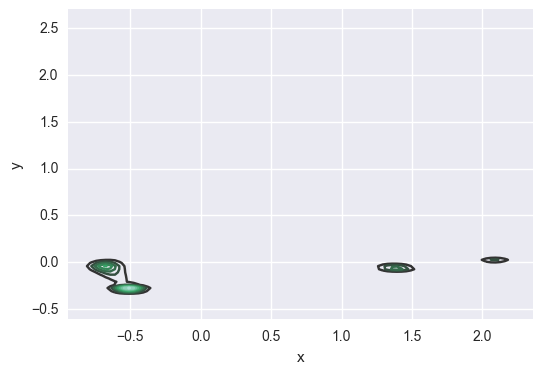

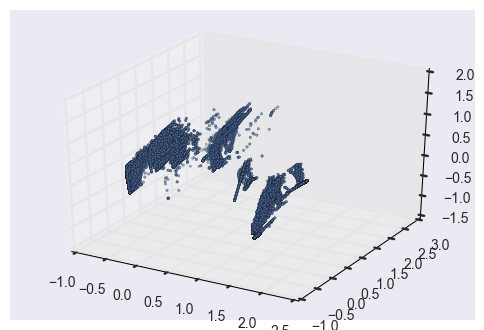

In [6]:
%matplotlib inline
from mpl_toolkits import mplot3d

# Since this is a multiattribute space, let us first plot the X spread in 
# two dimensions (PCA factorization) to see if there is any trend
from sklearn.decomposition import PCA

# Create a dimensional projector
pca = PCA(n_components=3)

# Transform the input space
X_formed = pd.DataFrame(
    pca.fit(X_train).transform(X_train), columns=['x', 'y', 'z'])

# Show a preview of the transformed X, Y coordinates in 2 dimensions before plot
display(X_formed.head())

# Plot charts - 2D first
sns.kdeplot(X_formed.x, X_formed.y, linewidth=0.05)
plt.show()

# Plot in 3D too
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_formed.x, X_formed.y, X_formed.z, s=3, zdir='z')
plt.show()

## Test/Predict

Using the hold-out dataset (the 2% we saved earlier), predict if the outlier transactions are being correctly predicted outside the glob spaces or inside? 

How accurate is the machine in predicting the outlier/fraudulent transactions? We will use both known normal activity and intrusion activity to study the % accuracy of prediction.

In [7]:
# Predict for X_test
# Filter for all known outliers (aka non normal status records)
known_outliers = test_set[test_set.is_attack == 0]
known_non_outliers = test_set[test_set.is_attack == 1]

# Strip the class label and ask to predict by the one-class SVM
y_pred_outliers = clf.predict(X_set(known_outliers))
y_pred_nonoutliers = clf.predict(X_set(known_non_outliers))

# Print accuracy
display(
    HTML(
        "<h3>Accuracy of outlier and non-outlier detection is at {0:.2f}% and {1:.2f}% respectively</h3>".
        format(
            np.count_nonzero(y_pred_outliers == -1) * 100.0 / len(
                known_outliers),
            np.count_nonzero(y_pred_nonoutliers == 1) * 100.0 / len(
                known_non_outliers))))